In [1]:
# Required Libraries
%pip install -q qiskit[visualization]
%pip install -q qiskit_aer
%pip install -q qiskit_ibm_runtime
%pip install -q matplotlib

zsh:1: no matches found: qiskit[visualization]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Augmented BBM92 Protocol

In [1]:
import math
import numpy as np
import random
import re
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit_aer import AerSimulator

## *Simulation Without the Presence of an Eavesdropper*

### *Step 1: creating the singlets*

In the first step Alice and Bob receive their qubits of the singlet states $\lvert\psi_s\rangle$ created by Charlie.

For our simulation, we need registers with two quantum bits and four classical bits.

In [2]:
# Creating registers
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(4, name="cr")

Let us assume that qubits *qr\[0\]* and *qr\[1\]* belong to Alice and Bob respetively.
In classical bits *cr\[0\]* and *cr\[1\]* Alice and Bob store their measurement results, and classical bits *cr\[2\]* and *cr\[3\]* are used by Eve to store her measurement results of Alice's and Bob's qubits.

Now Charlie creates a singlet state:

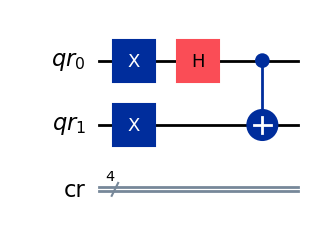

In [3]:
singlet = QuantumCircuit(qr, cr, name='singlet')
singlet.x(qr[0])
singlet.x(qr[1])
singlet.h(qr[0])
singlet.cx(qr[0],qr[1])

singlet.draw('mpl')

### *Measurement Circuits*

\begin{align*}
b_i = 1: \quad \vec{a}_1 = (1, 0, 0) \quad (X\text{ observable}) \qquad &
b_i = 2: \quad \vec{a}_2 = (0, 0, 1) \quad (Z\text{ observable})
\\
b_j' = 1: \quad \vec{b}_1 = (1, 0, 0) \quad (X\text{ observable}) \qquad &
b_j' = 2: \quad \vec{b}_2 = (0, 0, 1) \quad (Z\text{ observable})
\\
b_j' = 3: \quad \vec{b}_3 = \left(\frac{1}{\sqrt{2}}, 0, \frac{1}{\sqrt{2}}\right) \quad (W\text{ observable}) \qquad &
b_j' = 4: \quad \vec{b}_4 = \left(-\frac{1}{\sqrt{2}}, 0, \frac{1}{\sqrt{2}}\right) \quad (V\text{ observable})
\\
\end{align*}


In [4]:
## Alice's measurement circuits

# measure the spin projection of Alice's qubit onto the a_1 direction (X basis)
measureA1 = QuantumCircuit(qr, cr, name='measureA1')
measureA1.h(qr[0])
measureA1.measure(qr[0],cr[0])

# measure the spin projection of Alice's qubit onto the a_2 direction (standard Z basis)
measureA2 = QuantumCircuit(qr, cr, name='measureA2')
measureA2.measure(qr[0],cr[0])

## Bob's measurement circuits

# Key Generation Bases

# measure the spin projection of Bob's qubit onto the b_1 direction (X basis)
measureB1 = QuantumCircuit(qr, cr, name='measureB1')
measureB1.h(qr[1])
measureB1.measure(qr[1],cr[1])

# measure the spin projection of Bob's qubit onto the b_2 direction (standard Z basis)
measureB2 = QuantumCircuit(qr, cr, name='measureB2')
measureB2.measure(qr[1],cr[1])

# CHSH Value Calculation Bases

# measure the spin projection of Bob's qubit onto the b_3 direction (W basis)
measureB3 = QuantumCircuit(qr, cr, name='measureB3')
measureB3.s(qr[1])
measureB3.h(qr[1])
measureB3.t(qr[1])
measureB3.h(qr[1])
measureB3.measure(qr[1],cr[1])

# measure the spin projection of Bob's qubit onto the b_4 direction (V basis)
measureB4 = QuantumCircuit(qr, cr, name='measureB4')
measureB4.s(qr[1])
measureB4.h(qr[1])
measureB4.tdg(qr[1])
measureB4.h(qr[1])
measureB4.measure(qr[1],cr[1])

## Lists of measurement circuits
aliceMeasurements = [measureA1, measureA2]
bobMeasurements = [measureB1, measureB2, measureB3, measureB4]

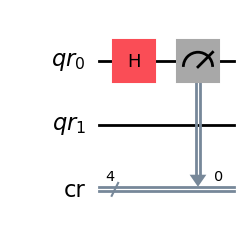

In [5]:
measureA1.draw('mpl')

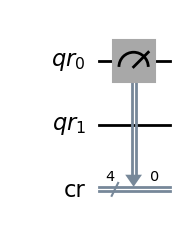

In [6]:
measureA2.draw('mpl')

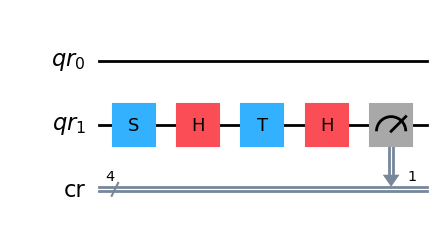

In [7]:
measureB3.draw('mpl')

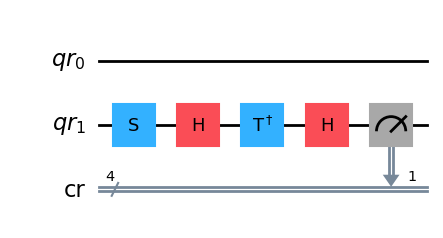

In [8]:
measureB4.draw('mpl')

### *QBER Calculation*

In [9]:
# QBER Part needs to be added here
def calculate_qber(aliceKey, bobKey, disclose = 10):
    if (len(aliceKey) != len(bobKey)):
        return -1
    key_length = len(aliceKey)
    num_disclosed = max(1, int(np.floor((key_length * disclose/100))))
    disclosed_indices = random.sample(range(key_length), num_disclosed)
    numKeyMismatches = 0
    for i in disclosed_indices:
        if (aliceKey[i] != bobKey[i]):
            numKeyMismatches += 1
    return (numKeyMismatches/num_disclosed) * 100

### *CHSH correlation value test*

$$C =
\langle X\otimes W \rangle - \langle X \otimes V \rangle + \langle Z \otimes W \rangle + \langle Z \otimes V \rangle =
-2 \sqrt{2}. \qquad\qquad $$

Alice and Bob want to be sure that there was no interference in the communication session.
To do that, they calculate the CHSH correlation value $(3)$ using the results obtained after the measurements of spin projections onto the $\vec{a}_1/\vec{b}_3$, $\vec{a}_1/\vec{b}_4$, $\vec{a}_2/\vec{b}_3$ and $\vec{a}_2/\vec{b}_4$ directions.
Recall that it is equivalent to the measurement of the observables $X \otimes W$, $X \otimes V$, $Z \otimes W$ and $Z \otimes V$ respectively.

$$\langle A(\vec{a}_i) \otimes B(\vec{b}_j) \rangle =
  \mathrm{P}(-1,-1) - \mathrm{P}(1,-1) - \mathrm{P}(-1,1) + \mathrm{P}(1,1). \qquad\qquad$$

$$\mathrm{P}(a_j, b_k) = \frac{n_{a_j, b_k}(A \otimes B)}{N(A \otimes B)} \qquad\qquad$$

In [10]:
# function that calculates CHSH correlation value
def chsh_corr(result, circuits, numberOfSinglets, aliceMeasurementChoices, bobMeasurementChoices, abPatterns):

    # lists with the counts of measurement results
    # each element represents the number of (-1,-1), (1,-1), (-1,1) and (1,1) results respectively
    countA1B3 = [0, 0, 0, 0] # XW observable
    countA1B4 = [0, 0, 0, 0] # XV observable
    countA2B3 = [0, 0, 0, 0] # ZW observable
    countA2B4 = [0, 0, 0, 0] # ZV observable

    for i in range(numberOfSinglets):

        res = list(result.get_counts(circuits[i]).keys())[0]

        # if the spins of the qubits of the i-th singlet were projected onto the a_1/b_3 directions
        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B3[j] += 1
        # if the spins of the qubits of the i-th singlet were projected onto the a_1/b_4 directions
        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 4):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B4[j] += 1
        # if the spins of the qubits of the i-th singlet were projected onto the a_2/b_3 directions
        if (aliceMeasurementChoices[i] == 2 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA2B3[j] += 1

        # if the spins of the qubits of the i-th singlet were projected onto the a_2/b_4 directions
        if (aliceMeasurementChoices[i] == 2 and bobMeasurementChoices[i] == 4):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA2B4[j] += 1

    # number of the results obtained from the measurements in a particular basis
    total13 = sum(countA1B3)
    total14 = sum(countA1B4)
    total23 = sum(countA2B3)
    total24 = sum(countA2B4)

    # expectation values of XW, XV, ZW and ZV observables (2)
    expect13 = (countA1B3[0] - countA1B3[1] - countA1B3[2] + countA1B3[3])/total13 # -1/sqrt(2)
    expect14 = (countA1B4[0] - countA1B4[1] - countA1B4[2] + countA1B4[3])/total14 # 1/sqrt(2)
    expect23 = (countA2B3[0] - countA2B3[1] - countA2B3[2] + countA2B3[3])/total23 # -1/sqrt(2)
    expect24 = (countA2B4[0] - countA2B4[1] - countA2B4[2] + countA2B4[3])/total24 # -1/sqrt(2)

    corr = expect13 - expect14 + expect23 + expect24 # calculate the CHSH correlation value (3)

    return corr

In [11]:
def bbm92_without_eavesdropping(numberOfSinglets = 5500, disclose_rate = 11, log = False):
    # Defining Measurement Choices:
    if (log):
        print("Defining Measurement Choices...")
    aliceMeasurementChoices = [random.randint(1, 2) for i in range(numberOfSinglets)] # string b of Alice
    bobMeasurementChoices = [] # string b' of Bob
    bobSignalOrTest = [random.randint(1, 4) for i in range(numberOfSinglets)]
    # (1/4)th = CHSH Test, (3/4)th = Key Generation
    for i in range(len(bobSignalOrTest)):
        if bobSignalOrTest[i] == 1:
            # Test Measurements
            bobMeasurementChoices.append(random.randint(3, 4))
        else:
            # Signal Meaaurements
            bobMeasurementChoices.append(random.randint(1, 2))
    if (log):
        print("Defining Circuits and Applying Measurement Circuits as per the choices...")
    # Circuits
    circuits = []

    for i in range(numberOfSinglets):
        circuitName = f"Singlet{i}: A{aliceMeasurementChoices[i]}_B{bobMeasurementChoices[i]}"
        singletCircuit = singlet.copy()

        # Retrieve Alice's and Bob's measurement circuits
        aliceCircuitMeasurement = aliceMeasurements[aliceMeasurementChoices[i] - 1]
        bobCircuitMeasurement = bobMeasurements[bobMeasurementChoices[i] - 1]

        singletCircuit.barrier()

        # Combine the circuits (assuming sequential composition)
        singletCircuit = singletCircuit.compose(aliceCircuitMeasurement)
        singletCircuit.barrier()
        singletCircuit = singletCircuit.compose(bobCircuitMeasurement)
        singletCircuit.name = circuitName

        # Add the circuit to the list
        circuits.append(singletCircuit)

    if (log):
        print("Measuring Circuits using a backend simulator...")

    backend = AerSimulator()
    job = backend.run(circuits, shots = 1)
    results = job.result()

    abPatterns = [
        re.compile('..00$'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
        re.compile('..01$'), # search for the '..01' output (Alice obtained 1 and Bob obtained -1)
        re.compile('..10$'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
        re.compile('..11$')  # search for the '..11' output (Alice obtained 1 and Bob obtained 1)
    ]

    if (log):
        print("Analysing Results...")

    aliceResults = []
    bobResults = []

    for i in range(numberOfSinglets):

        res = list(results.get_counts(circuits[i]).keys())[0] # extract the key from the dict and transform it to str; execution result of the i-th circuit

        if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(-1) # Bob got the result -1
        if abPatterns[1].search(res):
            aliceResults.append(1)
            bobResults.append(-1)
        if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(1) # Bob got the result 1
        if abPatterns[3].search(res):
            aliceResults.append(1)
            bobResults.append(1)

    if (log):
        print("Generating the key...")

    aliceKey = []
    bobKey = []

    # comparing the stings with measurement choices
    for i in range(numberOfSinglets):
        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 1) or (aliceMeasurementChoices[i] == 2 and bobMeasurementChoices[i] == 2):
            aliceKey.append(aliceResults[i]) # record the i-th result obtained by Alice as the bit of the secret key k
            bobKey.append(-bobResults[i]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'

    keyLength = len(aliceKey) # length of the secret key

    abKeyMismatches = 0 # number of mismatching bits in Alice's and Bob's keys

    for j in range(keyLength):
        if aliceKey[j] != bobKey[j]:
            abKeyMismatches += 1

    if (log):
        print("Calculating QBER...")

    error_rate = calculate_qber(aliceKey, bobKey)

    if (log):
        print("Calculating Correlation Value...")

    corr = chsh_corr(results, circuits, numberOfSinglets, aliceMeasurementChoices, bobMeasurementChoices, abPatterns) # CHSH correlation value

    if (log):
        print("---------------------")
        print("Protocol Summary: ")
        # Keys
        print(f"Total Number of Qubits Exchanged: " + str(numberOfSinglets))
        print(f"Alice's Key: {aliceKey}")
        print(f"Bob's key: {bobKey}")
        print(f"QBER with disclose rate {disclose_rate}%: {error_rate}")
        print('Length of the key: ' + str(keyLength))
        print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

        # CHSH inequality test
        print('CHSH correlation value: ' + str(round(corr, 3)))

    return keyLength, error_rate, corr

In [12]:
result = bbm92_without_eavesdropping(log=True)

Defining Measurement Choices...
Defining Circuits and Applying Measurement Circuits as per the choices...
Measuring Circuits using a backend simulator...
Analysing Results...
Generating the key...
Calculating QBER...
Calculating Correlation Value...
---------------------
Protocol Summary: 
Total Number of Qubits Exchanged: 5500
Alice's Key: [-1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1

## *Simulation of eavesdropping*

### *Measurement Circuits*

In [13]:
# measurement of the spin projection of Alice's qubit onto the a_1 direction (X basis)
measureEA1 = QuantumCircuit(qr, cr, name='measureEA1')
measureEA1.h(qr[0])
measureEA1.measure(qr[0],cr[2])

# measurement of the spin projection of Alice's qubit onto the a_2 direction (standard Z basis)
measureEA2 = QuantumCircuit(qr, cr, name='measureEA3')
measureEA2.measure(qr[0],cr[2])

# measurement of the spin projection of Bob's qubit onto the b_1 direction (X basis)
measureEB1 = QuantumCircuit(qr, cr, name='measureEB1')
measureEB1.h(qr[1])
measureEB1.measure(qr[1],cr[3])

# measurement of the spin projection of Bob's qubit onto the b_2 direction (standard Z basis)
measureEB2 = QuantumCircuit(qr, cr, name='measureEB2')
measureEB2.measure(qr[1],cr[3])

# lists of measurement circuits
eveMeasurements = [measureEA1, measureEA2, measureEB1, measureEB2]

In [14]:
def bbm92_with_eavesdropping(numberOfSinglets = 5500, disclose_rate = 11, qber_threshold = 0.11, log = False):
    # Defining Measurement Choices:
    if (log):
        print("Defining Measurement Choices...")

    aliceMeasurementChoices = [random.randint(1, 2) for i in range(numberOfSinglets)] # string b of Alice
    bobMeasurementChoices = [] # string b' of Bob
    bobSignalOrTest = [random.randint(1, 4) for i in range(numberOfSinglets)]
    # (1/4)th = CHSH Test, (3/4)th = Key Generation
    for i in range(len(bobSignalOrTest)):
        if bobSignalOrTest[i] == 1:
            # Test Measurements
            bobMeasurementChoices.append(random.randint(3, 4))
        else:
            # Signal Meaaurements
            bobMeasurementChoices.append(random.randint(1, 2))

    if (log):
        print("Defining Circuits and Applying Measurement Circuits as per the choices...")

    # Circuits
    ABECircuits = []
    attack_probability = 4 * qber_threshold
    num_intercepts = 0
    intercepted_qubit_indices = []

    for j in range(numberOfSinglets):
        eveMeasurementChoices = []
        SingletCircuitABE = singlet.copy()
        eve_intercepts = np.random.rand() < attack_probability
        if (eve_intercepts):
            num_intercepts += 1
            intercepted_qubit_indices.append(j)
            if random.uniform(0, 1) <= 0.5: # in 50% of cases perform the XX measurement
                eveMeasurementChoices.append([0, 2])
            else:
                eveMeasurementChoices.append([1, 3])
            SingletCircuitABE.barrier()
            SingletCircuitABE = SingletCircuitABE.compose(eveMeasurements[eveMeasurementChoices[0][0]])
            SingletCircuitABE.barrier()
            SingletCircuitABE = SingletCircuitABE.compose(eveMeasurements[eveMeasurementChoices[0][1]])
            SingletCircuitABE.barrier()
            circuitName = f"SingletABE{j}:A{aliceMeasurementChoices[j]}_B{bobMeasurementChoices[j]}_E{eveMeasurementChoices[0][0]}{eveMeasurementChoices[0][1]}"
        else:
            circuitName = f"SingletABE{j}:A{aliceMeasurementChoices[j]}_B{bobMeasurementChoices[j]}_NoEavesdropping"

        SingletCircuitABE = SingletCircuitABE.compose(aliceMeasurements[aliceMeasurementChoices[j] - 1])
        SingletCircuitABE.barrier()
        SingletCircuitABE = SingletCircuitABE.compose(bobMeasurements[bobMeasurementChoices[j] - 1])

        SingletCircuitABE.name = circuitName
        # add the created circuit to the circuits list
        ABECircuits.append(SingletCircuitABE)

    if (log):
        print("Measuring Circuits using a backend simulator...")

    backend = AerSimulator()
    Eavesdropping_results = backend.run(ABECircuits, shots = 1).result()

    ePatterns = [
        re.compile('00..$'), # search for the '00..' result (Eve obtained the results -1 and -1 for Alice's and Bob's qubits)
        re.compile('01..$'), # search for the '01..' result (Eve obtained the results 1 and -1 for Alice's and Bob's qubits)
        re.compile('10..$'), # search for the '10..' result (Eve obtained the results -1 and 1 for Alice's and Bob's qubits)
        re.compile('11..$')  # search for the '11..' result (Eve obtained the results 1 and 1 for Alice's and Bob's qubits)
    ]

    abPatterns = [
        re.compile('..00$'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
        re.compile('..01$'), # search for the '..01' output (Alice obtained 1 and Bob obtained -1)
        re.compile('..10$'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
        re.compile('..11$')  # search for the '..11' output (Alice obtained 1 and Bob obtained 1)
    ]

    if (log):
        print("Analysing Results...")

    aliceResults = []
    bobResults = []
    eveResults = []

    for j in range(numberOfSinglets):
        res = list(Eavesdropping_results.get_counts(ABECircuits[j]).keys())[0] # extract a key from the dict and transform it to str
        # Alice and Bob
        if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(-1) # Bob got the result -1
        if abPatterns[1].search(res): # check if the key is '..01' (if the measurement results are 1,-1)
            aliceResults.append(1)
            bobResults.append(-1)
        if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(1) # Bob got the result 1
        if abPatterns[3].search(res): # check if the key is '..11' (if the measurement results are 1,1)
            aliceResults.append(1)
            bobResults.append(1)

        # Eve
        if ePatterns[0].search(res): # check if the key is '00..'
            eveResults.append([-1, -1]) # results of the measurement of Alice's and Bob's qubits are -1,-1
        if ePatterns[1].search(res): # check if the key is '01..'
            eveResults.append([1, -1]) # results of the measurement of Alice's and Bob's qubits are 1,-1
        if ePatterns[2].search(res): # check if the key is '10..'
            eveResults.append([-1, 1]) # results of the measurement of Alice's and Bob's qubits are -1,1
        if ePatterns[3].search(res): # check if the key is '11..'
            eveResults.append([1, 1]) # results of the measurement of Alice's and Bob's qubits are 1,1

    if (log):
        print("Generating the key...")

    aliceKey = [] # Alice's key string a
    bobKey = [] # Bob's key string a'
    eveKeys = [] # Eve's keys; the 1-st column is the key of Alice, and the 2-nd is the key of Bob

    keyIndices = [] # Indices of Qubits used for the key
    key_index_with_intercepted_qubit = [] # Indices of Alice's and Bob's Key which was formed using the qubits that was intercepted by Eve
    idx = 0
    # comparing the strings with measurement choices (b and b')
    for j in range(numberOfSinglets):
        # if Alice and Bob measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
        if (aliceMeasurementChoices[j] == 1 and bobMeasurementChoices[j] == 1) or (aliceMeasurementChoices[j] == 2 and bobMeasurementChoices[j] == 2):
            keyIndices.append(j)
            if j in intercepted_qubit_indices:
                key_index_with_intercepted_qubit.append(idx)
                eveKeys.append([eveResults[j][0], -eveResults[j][1]]) # record the i-th bits of the keys of Eve
            aliceKey.append(aliceResults[j]) # record the i-th result obtained by Alice as the bit of the secret key k
            bobKey.append(-bobResults[j]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'
            idx += 1

    keyLength = len(aliceKey) # length of the secret key

    if (log):
        print("Calculating Key Mismatches...")

    abKeyMismatches = 0 # number of mismatching bits in the keys of Alice and Bob
    eaKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Alice
    ebKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Bob

    for j in range(keyLength):
        if aliceKey[j] != bobKey[j]:
            abKeyMismatches += 1

    for j in range(len(key_index_with_intercepted_qubit)):
        if eveKeys[j][0] != aliceKey[key_index_with_intercepted_qubit[j]]:
            eaKeyMismatches += 1
        if eveKeys[j][1] != bobKey[key_index_with_intercepted_qubit[j]]:
            ebKeyMismatches += 1

    num_intercepts_used_in_key = len(key_index_with_intercepted_qubit);

    if (log):
        print("Calculating Eve's Knowledge of Alice's and Bob's Keys...")
    eaKnowledge = (num_intercepts_used_in_key - eaKeyMismatches)/num_intercepts_used_in_key # Eve's knowledge of Alice's key
    ebKnowledge = (num_intercepts_used_in_key - ebKeyMismatches)/num_intercepts_used_in_key # Eve's knowledge of Bob's key

    if (log):
        print("Calculating QBER...")
    error_rate = calculate_qber(aliceKey, bobKey)

    if (log):
        print("Calculating Correlation Value...")
    corr = chsh_corr(Eavesdropping_results, ABECircuits, numberOfSinglets, aliceMeasurementChoices, bobMeasurementChoices, abPatterns) # CHSH correlation value

    if (log):
        print("---------------------")
        print("Protocol Summary: ")
        print("Number of Qubits: " + str(numberOfSinglets))
        # Keys
        print('Length of the key: ' + str(keyLength))
        print('Number of mismatching bits: ' + str(abKeyMismatches))
        print(f"QBER with disclose rate of {disclose_rate}%: {error_rate}" + '\n')

        print('Number of qubits intercepted: ' + str(num_intercepts))
        print('Number of intercepted qubits used in the key: ' + str(num_intercepts_used_in_key) + "\n")

        # CHSH inequality test
        print('CHSH correlation value: ' + str(round(corr, 3)) + '\n')

        print('Eve Alice Key mismatches: ' + str(eaKeyMismatches))
        print('Eve Bob Key mismatches: ' + str(ebKeyMismatches) + '\n')

        print('Eve\'s knowledge of Alice\'s key: ' + str(round(eaKnowledge * 100, 2)) + ' %')
        print('Eve\'s knowledge of Bob\'s key: ' + str(round(ebKnowledge * 100, 2)) + ' %')

    return keyLength, error_rate, corr, eaKnowledge, ebKnowledge


In [15]:
result = bbm92_with_eavesdropping(numberOfSinglets=4000, log=True)

Defining Measurement Choices...
Defining Circuits and Applying Measurement Circuits as per the choices...
Measuring Circuits using a backend simulator...
Analysing Results...
Generating the key...
Calculating Key Mismatches...
Calculating Eve's Knowledge of Alice's and Bob's Keys...
Calculating QBER...
Calculating Correlation Value...
---------------------
Protocol Summary: 
Number of Qubits: 4000
Length of the key: 1489
Number of mismatching bits: 161
QBER with disclose rate of 11%: 7.4324324324324325

Number of qubits intercepted: 1766
Number of intercepted qubits used in the key: 644

CHSH correlation value: -2.258

Eve Alice Key mismatches: 172
Eve Bob Key mismatches: 159

Eve's knowledge of Alice's key: 73.29 %
Eve's knowledge of Bob's key: 75.31 %


# Graphs

### Number of Qubits v/s Correlation Value

#### With Eavesdropping

In [16]:
number_of_qubits = np.linspace(1000, 6000, 30)
number_of_qubits = np.round(number_of_qubits).astype(int)
correlation_values_with_eavesdropping = []
for i in range(len(number_of_qubits)):
    outputs = []
    for _ in range(30):
        value = bbm92_with_eavesdropping(numberOfSinglets=number_of_qubits[i])[2]
        outputs.append(value)
    correlation_values_with_eavesdropping.append(sum(outputs)/len(outputs))
    print(f"Circuit {i} done")

Circuit 0 done
Circuit 1 done
Circuit 2 done
Circuit 3 done
Circuit 4 done
Circuit 5 done
Circuit 6 done
Circuit 7 done
Circuit 8 done
Circuit 9 done
Circuit 10 done
Circuit 11 done
Circuit 12 done
Circuit 13 done
Circuit 14 done
Circuit 15 done
Circuit 16 done
Circuit 17 done
Circuit 18 done
Circuit 19 done
Circuit 20 done
Circuit 21 done
Circuit 22 done
Circuit 23 done
Circuit 24 done
Circuit 25 done
Circuit 26 done
Circuit 27 done
Circuit 28 done
Circuit 29 done


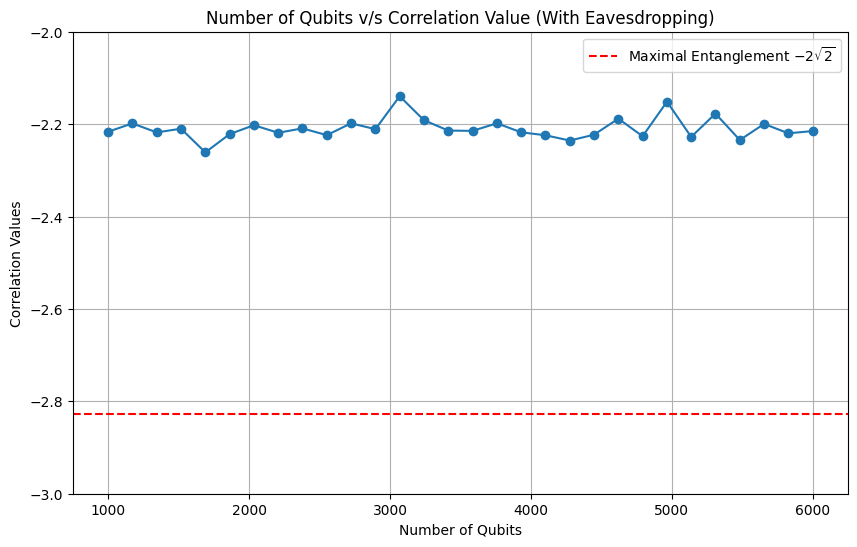

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(number_of_qubits, correlation_values_with_eavesdropping, marker='o')
plt.axhline(y=-2*math.sqrt(2), color='red', linestyle='--', label=r"Maximal Entanglement $-2\sqrt{2}$")
plt.title('Number of Qubits v/s Correlation Value (With Eavesdropping)')
plt.xlabel('Number of Qubits')
plt.ylabel('Correlation Values')
plt.ylim(-3, -2)
plt.legend()
plt.grid(True)
plt.show()

In cases of eavesdropping, the CHSH value appears to be varying between $-2.1$ and $-2.25$, which is suggestive of an attempt of eavesdropping since, the CHSH value has dropped from its maximum value of $-2\sqrt{2}$.

#### Without Eavesdropping

In [18]:
number_of_qubits = np.linspace(1000, 6000, 30)
number_of_qubits = np.round(number_of_qubits).astype(int)
correlation_values_without_eavesdropping = []
for i in range(len(number_of_qubits)):
    outputs = []
    for _ in range(30):
        value = bbm92_without_eavesdropping(numberOfSinglets=number_of_qubits[i])[2]
        outputs.append(value)
    correlation_values_without_eavesdropping.append(sum(outputs)/len(outputs))
    print(f"Circuit {i} done")

Circuit 0 done
Circuit 1 done
Circuit 2 done
Circuit 3 done
Circuit 4 done
Circuit 5 done
Circuit 6 done
Circuit 7 done
Circuit 8 done
Circuit 9 done
Circuit 10 done
Circuit 11 done
Circuit 12 done
Circuit 13 done
Circuit 14 done
Circuit 15 done
Circuit 16 done
Circuit 17 done
Circuit 18 done
Circuit 19 done
Circuit 20 done
Circuit 21 done
Circuit 22 done
Circuit 23 done
Circuit 24 done
Circuit 25 done
Circuit 26 done
Circuit 27 done
Circuit 28 done
Circuit 29 done


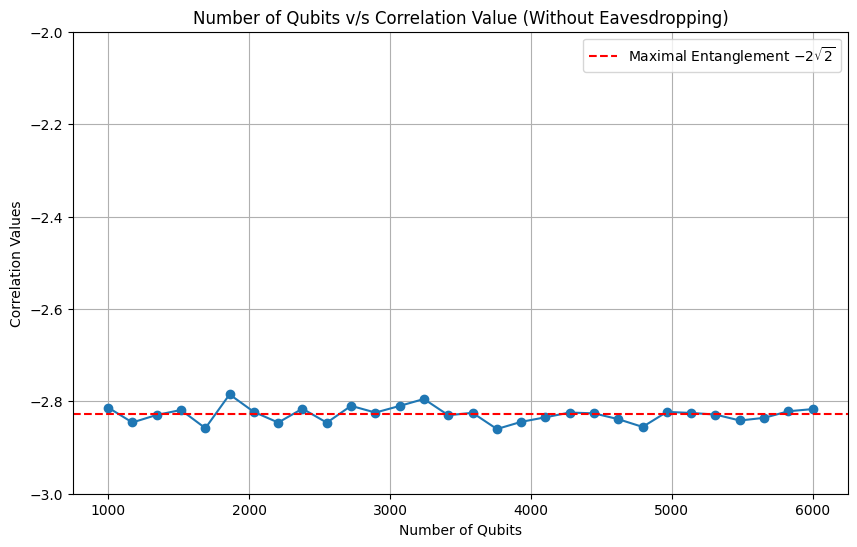

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(number_of_qubits, correlation_values_without_eavesdropping, marker='o')
plt.axhline(y=-2*math.sqrt(2), color='red', linestyle='--', label=r"Maximal Entanglement $-2\sqrt{2}$")
plt.title('Number of Qubits v/s Correlation Value (Without Eavesdropping)')
plt.xlabel('Number of Qubits')
plt.ylabel('Correlation Values')
plt.ylim(-3, -2)
plt.legend()
plt.grid(True)
plt.show()

In cases of without eavesdropping, the CHSH value appears to be varying between $-2.78$ and $-2.86$, which is suggestive of maximal entanglement of qubits. The CHSH value appears close to $-2\sqrt{2}$ on an average.

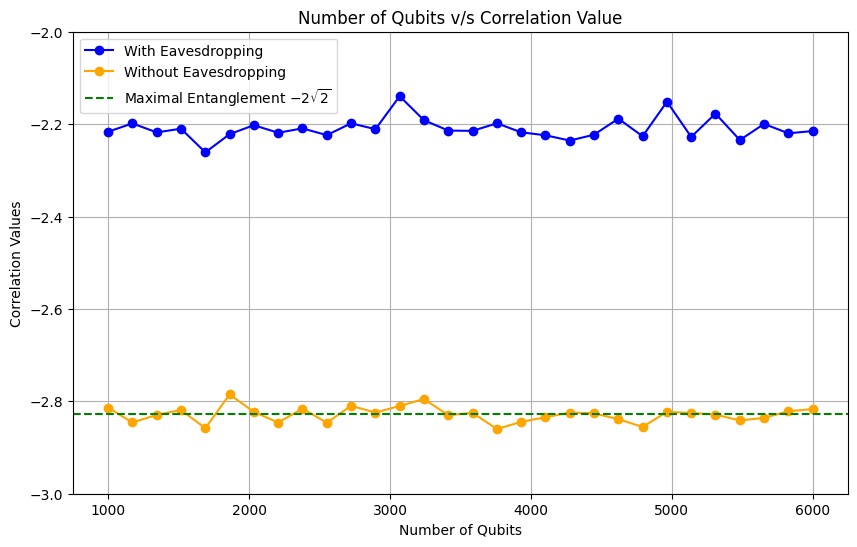

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(number_of_qubits, correlation_values_with_eavesdropping, marker='o', color="blue", label="With Eavesdropping")
plt.plot(number_of_qubits, correlation_values_without_eavesdropping, marker='o', color="orange", label="Without Eavesdropping")
plt.axhline(y=-2*math.sqrt(2), color='green', linestyle='--', label=r"Maximal Entanglement $-2\sqrt{2}$")
plt.title('Number of Qubits v/s Correlation Value')
plt.xlabel('Number of Qubits')
plt.ylabel('Correlation Values')
plt.ylim(-3, -2)
plt.legend()
plt.grid(True)
plt.show()

### QBER Threshold v/s Correlation Value, Eve's Knowledge of Alice's Key, Eve's Knowledge of Bob's Key

In [21]:
number_of_qubits = 5500
values = np.linspace(0.05, 0.20, 16)
qber_threshold_values = np.round(values, 2).tolist()
correlation_values_qber_threshold = []
eve_alice_knowledge = []
eve_bob_knowledge = []
for i in range(len(qber_threshold_values)):
    corr_val_outputs = []
    ea_outputs = []
    eb_outputs = []
    for _ in range(30):
        result = bbm92_with_eavesdropping(numberOfSinglets=number_of_qubits, qber_threshold=qber_threshold_values[i])
        corr_val = result[2]
        ea_val = result[3]
        eb_val = result[4]
        corr_val_outputs.append(corr_val)
        ea_outputs.append(ea_val)
        eb_outputs.append(eb_val)
    correlation_values_qber_threshold.append(sum(corr_val_outputs)/len(corr_val_outputs))
    eve_alice_knowledge.append(sum(ea_outputs)/len(ea_outputs))
    eve_bob_knowledge.append(sum(eb_outputs)/len(eb_outputs))
    print(f"Circuit {i} done")

Circuit 0 done
Circuit 1 done
Circuit 2 done
Circuit 3 done
Circuit 4 done
Circuit 5 done
Circuit 6 done
Circuit 7 done
Circuit 8 done
Circuit 9 done
Circuit 10 done
Circuit 11 done
Circuit 12 done
Circuit 13 done
Circuit 14 done
Circuit 15 done


In [22]:
import matplotlib.ticker as tck

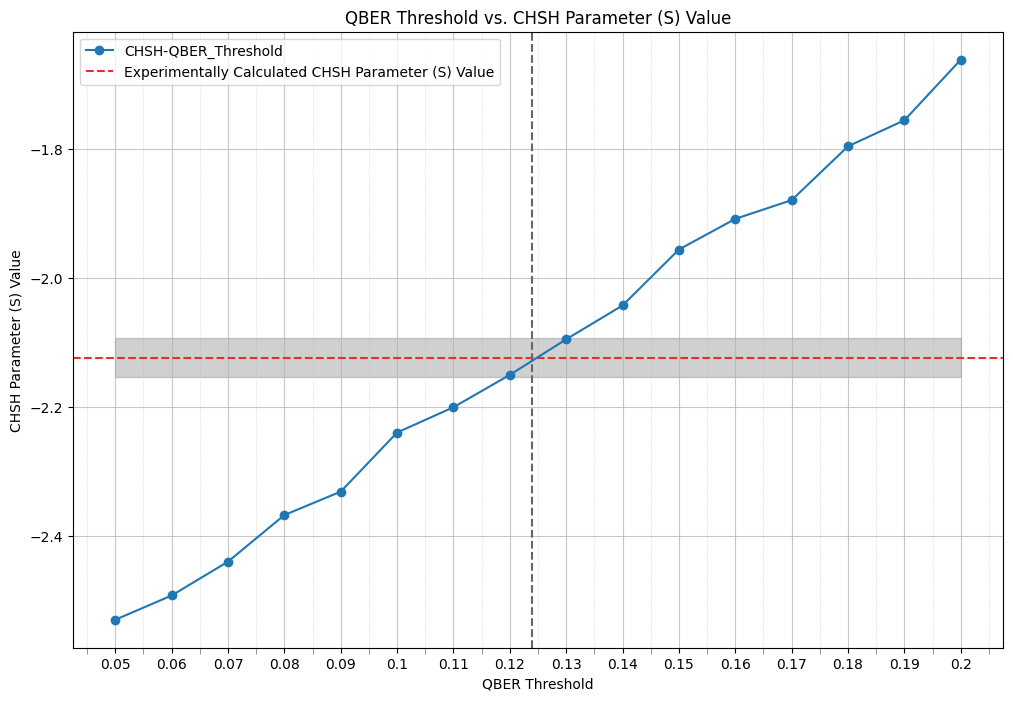

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(qber_threshold_values, correlation_values_qber_threshold, "o-", label="CHSH-QBER_Threshold", zorder=3)

ax.axhline(y=-2.123, color="#E72E2E", linestyle="--", label="Experimentally Calculated CHSH Parameter (S) Value")

ax.axvline(x=0.124, color="0.4", linestyle="--")

ax.fill_between(qber_threshold_values, -2.123 + 0.030, -2.123 - 0.030, color="0.4", alpha=0.3, zorder=1)

ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.01))

ax.xaxis.set_minor_locator(tck.MultipleLocator(base=0.005))

# Show minor ticks
ax.tick_params(axis='x', which='minor', length=4, color='gray')

ax.set_title("QBER Threshold vs. CHSH Parameter (S) Value")
ax.set_xlabel("QBER Threshold")
ax.set_ylabel("CHSH Parameter (S) Value")

# Grid: both major and minor
ax.grid(which='major', linestyle='-', linewidth=0.8, alpha=0.7)
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)

plt.legend()
plt.show()

In [24]:
print(correlation_values_qber_threshold)

[-2.5292829720128416, -2.4917232604749247, -2.439185833593932, -2.366977691261591, -2.330634670988635, -2.239015530263995, -2.199794488029033, -2.149635929250594, -2.094482429525556, -2.04202142774027, -1.9552820798373263, -1.9077538088557895, -1.878721320277626, -1.7952319156889696, -1.7548721078081122, -1.661013009748042]


In [25]:
print(eve_alice_knowledge)

[0.7514261292445988, 0.7468879541730569, 0.7539867976439479, 0.7543214791948079, 0.7502324762995468, 0.7479058403091212, 0.7569487184966958, 0.7509356772768803, 0.751239526568218, 0.7526512884702842, 0.7492659630375998, 0.7495546435216557, 0.7493839189518698, 0.7504064468311198, 0.7497231036337921, 0.7507556748391769]


In [26]:
print(eve_bob_knowledge)

[0.7582219470333331, 0.7452631518746848, 0.7538951190800256, 0.7534426294039388, 0.7489968355618318, 0.7485769724338124, 0.7491496696102686, 0.7470533805499643, 0.7470875987555952, 0.7539819602076457, 0.7442925897008027, 0.74919002293605, 0.7484980406721622, 0.7479387971319812, 0.7506637022258509, 0.7505489799609877]


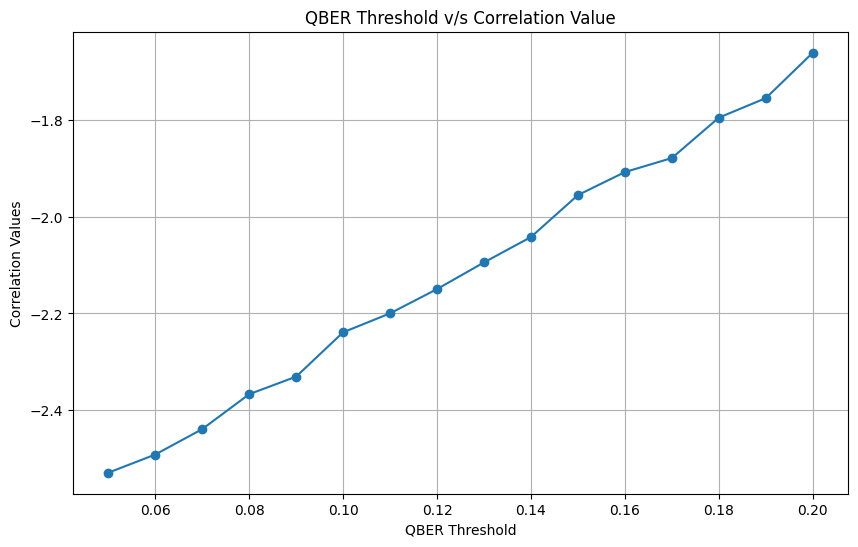

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(qber_threshold_values, correlation_values_qber_threshold, marker='o')
plt.title('QBER Threshold v/s Correlation Value')
plt.xlabel('QBER Threshold')
plt.ylabel('Correlation Values')
plt.grid(True)
plt.show()

An increased QBER threshold implies a higher probability of eavesdropping attacks. As the probability of attack rises, more qubits are intercepted, leading to a more significant decrease in the CHSH value from its theoretical maximum of $-2\sqrt{2}$

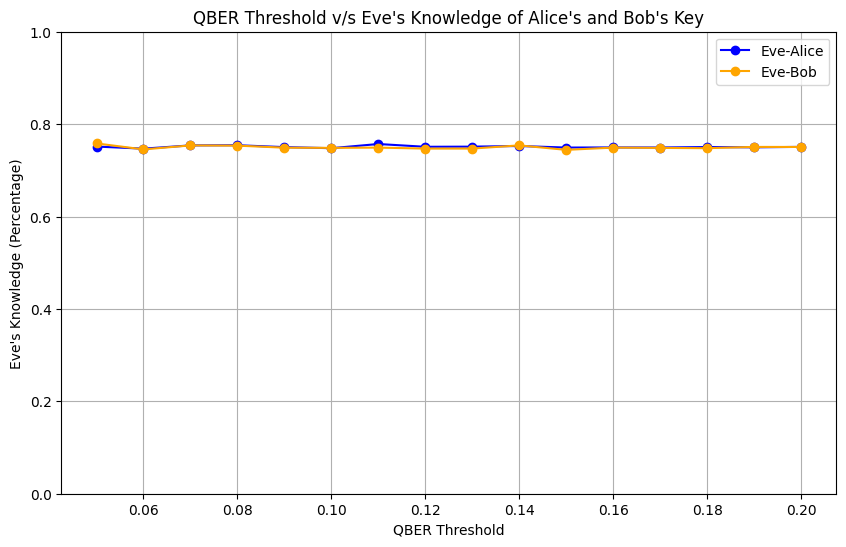

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(qber_threshold_values, eve_alice_knowledge, marker='o', label='Eve-Alice', color='blue')
plt.plot(qber_threshold_values, eve_bob_knowledge, marker='o', label='Eve-Bob', color='orange')
plt.title('QBER Threshold v/s Eve\'s Knowledge of Alice\'s and Bob\'s Key')
plt.xlabel('QBER Threshold')
plt.ylabel('Eve\'s Knowledge (Percentage)')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

Eve's Knowledge of Alice's and Bob's Keys (defined as the number of matching key values formed from those qubits that Eve had intercepted and got subsequently used in the formation of key) at all QBER Thresholds lies between $74.4\%$ and $75.8\%$. However, with the increase in the QBER Threshold, more number of qubits are intercepted and thus, Eve gains knowledge of more number of key values.

### On an average, how many times is the QBER Threshold is Violated during an Eavesdropping (30 Eavesdropping Simulations for each QBER Threshold)

In [29]:
number_of_qubits = 5500
values = np.linspace(0.07, 0.12, 6)
qber_threshold_values = np.round(values, 2).tolist()
qber_violations = []
for i in range(len(qber_threshold_values)):
    cnt = 0
    for _ in range(30):
        error_rate = bbm92_with_eavesdropping(numberOfSinglets=number_of_qubits, qber_threshold=qber_threshold_values[i])[1]
        if error_rate > (qber_threshold_values[i] * 100 + 1):
            cnt += 1
    qber_violations.append(cnt)
    print(f"Circuit {i} done")

Circuit 0 done
Circuit 1 done
Circuit 2 done
Circuit 3 done
Circuit 4 done
Circuit 5 done


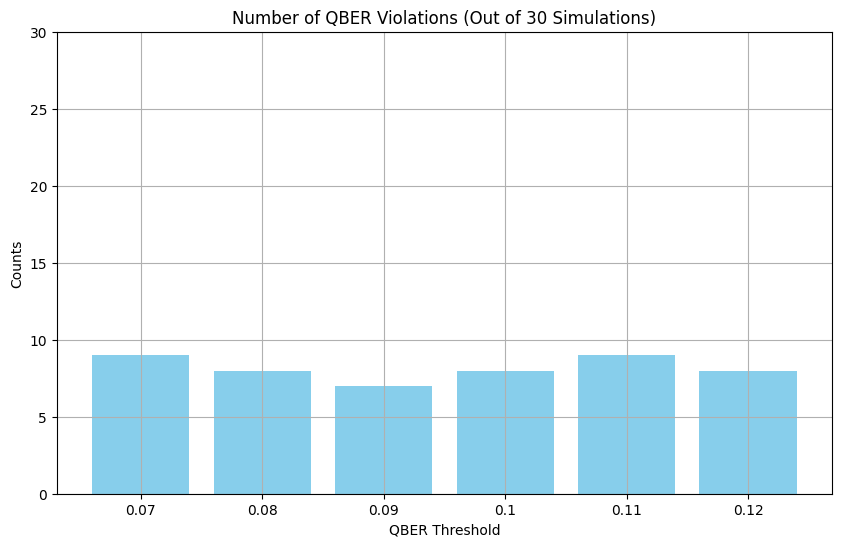

In [30]:
plt.figure(figsize=(10, 6))
qber_threshold_labels = [str(val) for val in qber_threshold_values]
plt.bar(qber_threshold_labels, qber_violations, color="skyblue")
plt.title("Number of QBER Violations (Out of 30 Simulations)")
plt.xlabel("QBER Threshold")
plt.ylabel("Counts")
plt.ylim(0, 30)
plt.grid(True)
plt.show()